# TODO:
#### João:
- [x] cena das datas passar horas para tarde/noite/manha/madrugada && dividr dias do mes e mes // Semi Done not sure what to do with month and days divider
- [x] nominal to numeric | NOminal value discretization using label Encoding
- [] outliers
- [] noise  NOTE: Binning is a technique for data smoothing. Data smoothing is employed to removenoise from data.
- [x] duplicated Records 

#### Jorge
- [x] Binning
- [x] feature scalling
- [x] svn
- [x] training and testing data

# Dados e Aprendizagem Automática
## Trabalho Prático
### Grupo 13
### Membros:
- (PG50304) Cristiano Pereira
- (PG50463) João Martins
- (PG50506) Jorge Lima
- (PG50733) Rúben Santos

Notebook structure:
- 1. Importing libraries
- 2. Loading the dataset
- 3. Exploratory Data Analysis TODO Joao
- 4. Data Preprocessing TODO Joao
- 5. Model Training TODO Jorge
- 6. Model Evaluation TODO Jorge
- 7. Model Selection TODO Jorge
- 8. Conclusion Todo

## 1. Importing libraries

In [265]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Lois
from lois import lois_ds_report
%matplotlib inline

## 2. Loading the dataset

In [266]:
trainingData = pd.read_csv('data/training_data.csv')
testData = pd.read_csv('data/test_data.csv')

## 3. Exploratory Data Analysis TODO Joao

╭─────────────────────────────────────────── Exploratory Data Anlysis ────────────────────────────────────────────╮
│                                                                                                                 │
╰──────────────────────────────────── EDA|simple| Suitable for data scientist ────────────────────────────────────╯

Shape Analysis
┗━━ Dataset Shape Analysis
    ┣━━ Dataset head
    ┣━━ General info 
    ┣━━ The target variable
    ┣━━ Number of rows and columns
    ┣━━ The different data types
    ┃   ┣━━ The sum of different variable type
    ┃   ┗━━ Visual representation of different variable type
    ┗━━ Analyze missing value
        ┣━━ The percentage of missing value in each columns
        ┣━━ The missing value counts
        ┗━━ Visual representation of missing value

╭──────────────────────────────────────────── DATASET SHAPE ANALYSIS ─────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

-------------------- THE HEAD OF YOUR DATASET --------------------

Your dataset is too large ; only the first 8 columns will be display

                                                    The Dataset                                                    
┏━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ city… ┃ magnitude_of_… ┃ delay_in_se… ┃ affected_… ┃ record… ┃ lumin… ┃ avg_tempera… ┃ avg_atm_pre… ┃ avg_humi… ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
└───────┴────────────────┴──────────────┴────────────┴─────────┴────────┴──────────────┴──────────────┴───────────┘

-------------------- SOME GENERAL INFO ABOUT YOUR DATASET --------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_name           5000 non-null   object 
 1   magnitude_of_delay  5000 non-null   object 
 2   delay_in_seconds    5000 non-null   int64  
 3   affected_roads      4915 non-null   object 
 4   record_date         5000 non-null   object 
 5   luminosity          5000 non-null   object 
 6   avg_temperature     5000 non-null   float64
 7   avg_atm_pressure    5000 non-null   float64
 8   avg_humidity        5000 non-null   float64
 9   avg_wind_speed      5000 non-null   float64
 10  avg_precipitation   5000 non-null   float64
 11  avg_rain            5000 non-null   object 
 12  incidents           5000 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 507.9+ KB


-------------------- THE TARGET VARIABLE OF YOUR DATASET --------------------

╭───────────────────────────────────────╮
│ The Target variable is : 'incidents'  │
╰───────────────────────────────────────╯

-------------------- ROWS AND COLUMNS IN YOUR DATASET --------------------

╭─ Shape output ─╮
│ (5000, 13)     │
╰────────────────╯

╭────────────────────────────────────────────────╮
│ Your dataset contains 5000 Rows and 13 Columns │
╰────────────────────────────────────────────────╯

-------------------- THE DATA TYPES IN YOUR DATASET --------------------

╭─ Data types output ─╮
│ object     7        │
│ float64    5        │
│ int64      1        │
│ dtype: int64        │
╰─────────────────────╯

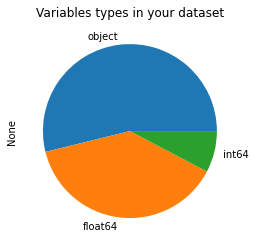

-------------------- MISSING VALUE IN YOUR DATASET --------------------

╭─── Missing value output ────╮
│ city_name             0.000 │
│ magnitude_of_delay    0.000 │
│ delay_in_seconds      0.000 │
│ record_date           0.000 │
│ luminosity            0.000 │
│ avg_temperature       0.000 │
│ avg_atm_pressure      0.000 │
│ avg_humidity          0.000 │
│ avg_wind_speed        0.000 │
│ avg_precipitation     0.000 │
│ avg_rain              0.000 │
│ incidents             0.000 │
│ affected_roads        0.017 │
│ dtype: float64              │
╰─────────────────────────────╯

╭─ Missing value counts output ─╮
│ 0.017     1                   │
│ 0.000    12                   │
│ dtype: int64                  │
╰───────────────────────────────╯

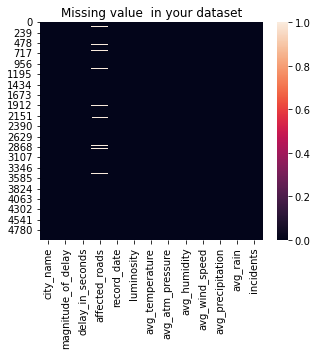

#################### END ####################

In [267]:
lois_ds_report(trainingData,target_variable="incidents")

In [268]:
trainingData.head()

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain,incidents
0,Guimaraes,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,0.0,Sem Chuva,None
1,Guimaraes,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,0.0,Sem Chuva,None
2,Guimaraes,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,0.0,Sem Chuva,Low
3,Guimaraes,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,0.0,Sem Chuva,Very_High
4,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,0.0,Sem Chuva,High


In [269]:
trainingData.describe()

,delay_in_seconds,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0
mean,560.567000,14.583000,1018.145000,74.455000,1.253500,0.0
std,1686.859581,4.820514,5.174372,17.204638,1.269847,0.0
min,0.000000,1.000000,997.000000,6.000000,0.000000,0.0
25%,0.000000,11.000000,1015.000000,63.000000,0.000000,0.0
50%,0.000000,14.000000,1019.000000,78.000000,1.000000,0.0
75%,234.000000,18.000000,1022.000000,90.000000,2.000000,0.0
max,31083.000000,35.000000,1032.000000,100.000000,10.000000,0.0


In [270]:
trainingData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_name           5000 non-null   object 
 1   magnitude_of_delay  5000 non-null   object 
 2   delay_in_seconds    5000 non-null   int64  
 3   affected_roads      4915 non-null   object 
 4   record_date         5000 non-null   object 
 5   luminosity          5000 non-null   object 
 6   avg_temperature     5000 non-null   float64
 7   avg_atm_pressure    5000 non-null   float64
 8   avg_humidity        5000 non-null   float64
 9   avg_wind_speed      5000 non-null   float64
 10  avg_precipitation   5000 non-null   float64
 11  avg_rain            5000 non-null   object 
 12  incidents           5000 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 507.9+ KB


## 4. Data Preprocessing TODO Joao

### Look for any Duplicated Values

In [271]:

trainingData[trainingData.duplicated()]


,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain,incidents


### Handle missing values

In [272]:
# collum affected_roles to numeric

def count_roads(affected_roads):
    #check if affected_roads is a float(nan values)
    if isinstance(affected_roads, float) and np.isnan(affected_roads):
        return 0
    return len(affected_roads.split(','))

# count the number of different roads affected
def count_roads(affected_roads):
    #check if affected_roads is a float(nan values)
    if isinstance(affected_roads, float) and np.isnan(affected_roads):
        return 0
    result = []
    return len([result.append(x) for x in affected_roads.split(',') if x not in result] )


trainingData['number_affected_roads'] = trainingData['affected_roads'].apply(count_roads)
testData['number_affected_roads'] = testData['affected_roads'].apply(count_roads)
trainingData['number_different_affected_roads'] = trainingData['affected_roads'].apply(count_roads)
testData['number_different_affected_roads'] = testData['affected_roads'].apply(count_roads)

print(trainingData.head())

   city_name magnitude_of_delay  delay_in_seconds  \
0  Guimaraes          UNDEFINED                 0   
1  Guimaraes          UNDEFINED               385   
2  Guimaraes          UNDEFINED                69   
3  Guimaraes              MAJOR              2297   
4  Guimaraes          UNDEFINED                 0   

                                      affected_roads       record_date  \
0                                                  ,  2021-03-15 23:00   
1                                              N101,  2021-12-25 18:00   
2                                                  ,  2021-03-12 15:00   
3  N101,R206,N105,N101,N101,N101,N101,N101,N101,N...  2021-09-29 09:00   
4                          N101,N101,N101,N101,N101,  2021-06-13 11:00   

  luminosity  avg_temperature  avg_atm_pressure  avg_humidity  avg_wind_speed  \
0       DARK             12.0            1013.0          70.0             1.0   
1       DARK             12.0            1007.0          91.0             

---

In [273]:
#testing if exists null values
# TODO: Coorect to drop the affected_roads collumn?
trainingData.drop('affected_roads', axis=1, inplace=True)
testData.drop('affected_roads', axis=1, inplace=True)
trainingData.isna().any()

city_name                          False
magnitude_of_delay                 False
delay_in_seconds                   False
record_date                        False
luminosity                         False
avg_temperature                    False
avg_atm_pressure                   False
avg_humidity                       False
avg_wind_speed                     False
avg_precipitation                  False
avg_rain                           False
incidents                          False
number_affected_roads              False
number_different_affected_roads    False
dtype: bool

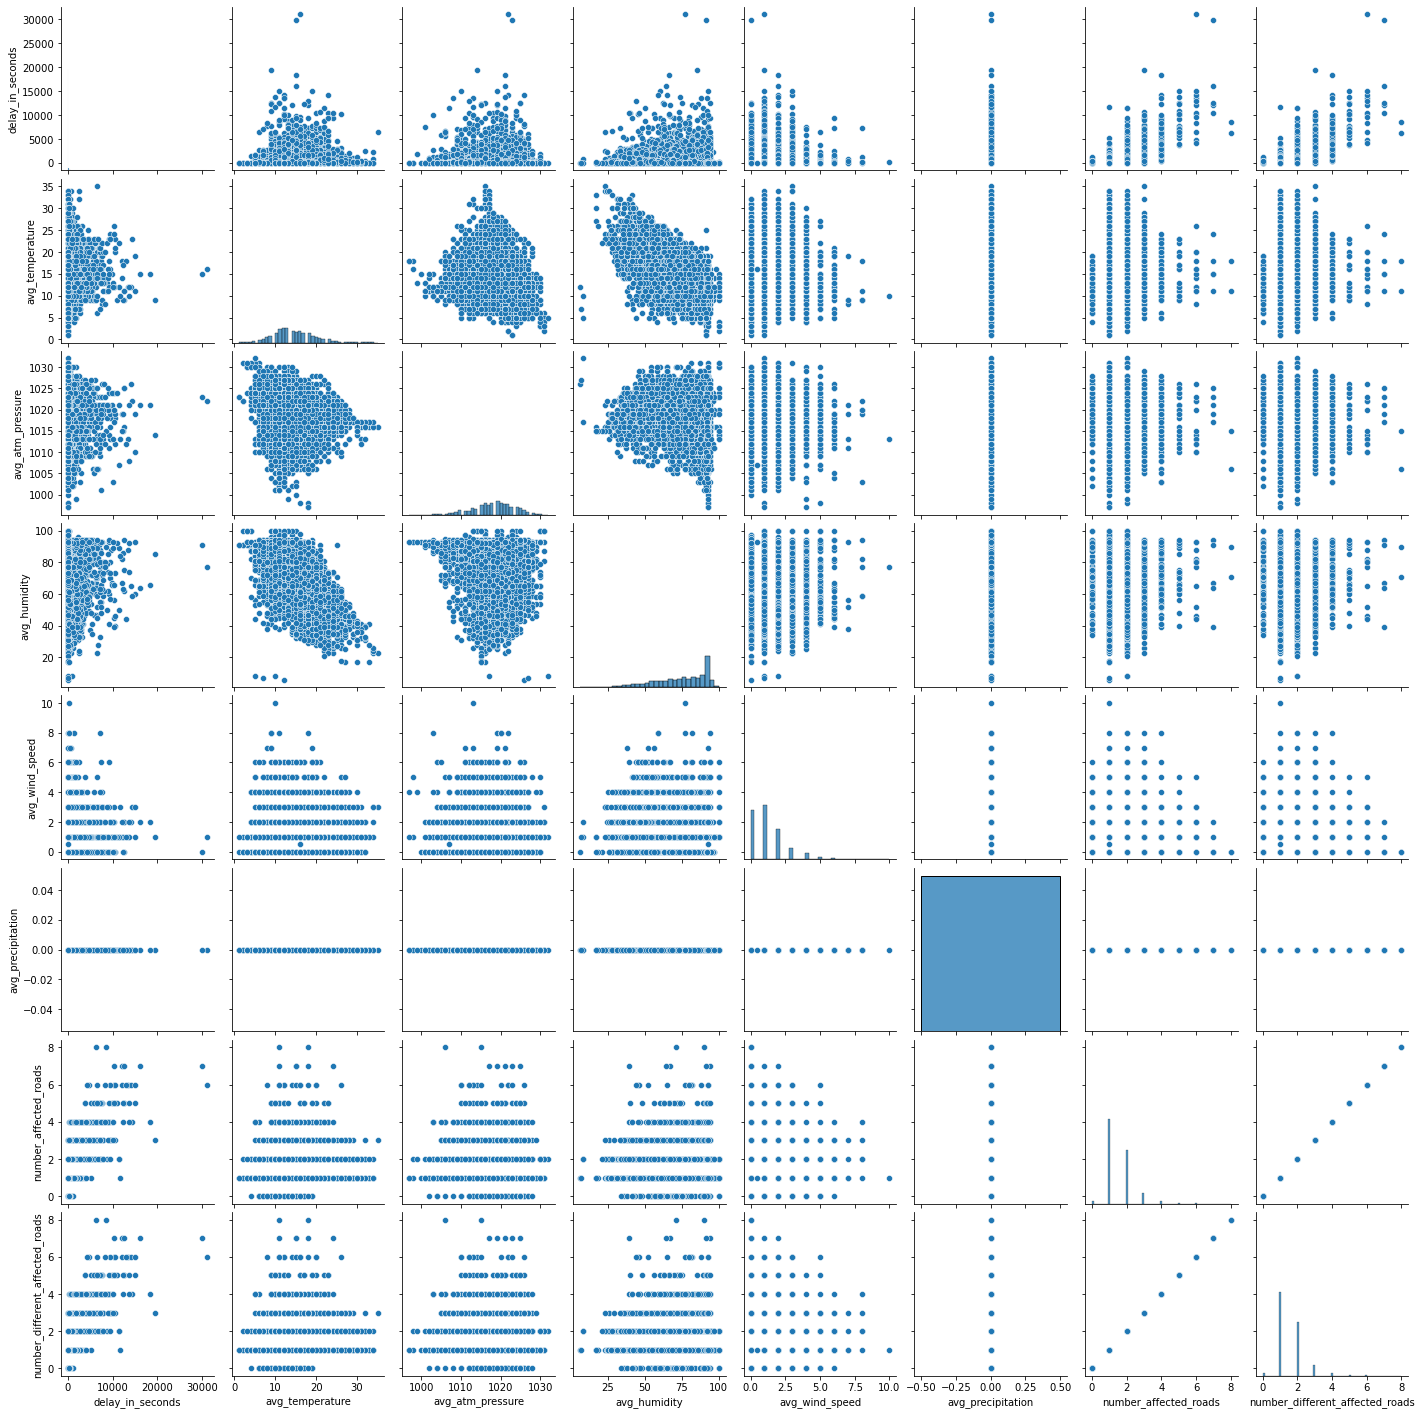

In [274]:
sns.pairplot(trainingData)

In [275]:
trainingData.profile_report(minimal=True)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ <ipython-input-275-3c17606ffb04>:1 in <module>                                                   │
│                                                                                                  │
│ /home/lcmj/anaconda3/envs/daa/lib/python3.6/site-packages/pandas/core/generic.py:5141 in         │
│ __getattr__                                                                                      │
│                                                                                                  │
│    5138 │   │   else:                                                                            │
│    5139 │   │   │   if self._info_axis._can_hold_identifiers_and_holds_name(name):               │
│    5140 │   │   │   │   return self[name]                                                        │
│ ❱  5141 │   │   │   return object.__getattribute__(self, name)                                   │
│    5142 │                                                                                        │
│    5143 │   def __setattr__(self, name: str, value) -> None:                                     │
│    5144 │   │   """                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'DataFrame' object has no attribute 'profile_report'

##### Dropping city_name because it's only data from Guimaraes

In [276]:
#Remove city_name column, only guimaraes is present
trainingData.drop('city_name',axis=1,inplace=True)
testData.drop('city_name',axis=1,inplace=True)


# Turn values to Numeric

###  Turn nominal values to numeric

In [277]:
dict_magnitude_of_delay = {'UNDEFINED': 0, 'MODERATE':1, 'MAJOR':3}
trainingData['magnitude_of_delay'] = trainingData['magnitude_of_delay'].map(dict_magnitude_of_delay)
testData['magnitude_of_delay'] = testData['magnitude_of_delay'].map(dict_magnitude_of_delay)

dict_luminosity = {'LOW_LIGHT': 0, 'LIGHT':1, 'DARK':2}
trainingData['luminosity'] = trainingData['luminosity'].map(dict_luminosity)
testData['luminosity'] = testData['luminosity'].map(dict_luminosity)

dict_avg_rain = {'Sem Chuva': 0, 'chuva fraca': 1, 'chuva moderada': 2, 'chuva forte': 3}
trainingData['avg_rain'] = trainingData['avg_rain'].map(dict_avg_rain)
testData['avg_rain'] = testData['avg_rain'].map(dict_avg_rain)

#### categorizing time of day

In [278]:
# Turn column record_date into manha,tarde,noite or madrugada
def turn_date_into_time_of_day(record_date):
    hour = int(record_date.split(' ')[1].split(':')[0])
    if hour >= 6 and hour < 12:
        return 'manha'
    elif hour >= 12 and hour < 18:
        return 'tarde'
    elif hour >= 18 and hour < 24:
        return 'noite'
    else:
        return 'madrugada'


trainingData['time_of_day'] = trainingData['record_date'].apply(turn_date_into_time_of_day)
testData['time_of_day'] = testData['record_date'].apply(turn_date_into_time_of_day)

dict_time_of_day = {'manha': 0, 'tarde':1, 'noite':2, 'madrugada':3}
trainingData['time_of_day'] = trainingData['time_of_day'].map(dict_time_of_day)
testData['time_of_day'] = testData['time_of_day'].map(dict_time_of_day)

In [279]:
#add 2 column with the month and day from time_of_day
trainingData['month'] = pd.DatetimeIndex(trainingData['record_date']).month
testData['month'] = pd.DatetimeIndex(testData['record_date']).month
trainingData['day'] = pd.DatetimeIndex(trainingData['record_date']).day
testData['day'] = pd.DatetimeIndex(testData['record_date']).day

In [280]:
corr_matrix = trainingData.corr(numeric_only=True)
sns.heatmap(corr_matrix,vmin=1,vmax=1,square=True, annot=True)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ <ipython-input-280-b55a0b36fcb5>:1 in <module>                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: corr() got an unexpected keyword argument 'numeric_only'

### Binning

In [281]:
from sklearn.preprocessing import KBinsDiscretizer

def apply_binning(data, column, n_bins, encode='ordinal', strategy='quantile'):
    if column in data.columns:
        estimater = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
        data[column + "_binned"] = estimater.fit_transform(data[[column]])
        data.drop(column, axis=1, inplace=True)


#apply_binning(testingData, 'avg_atm_pressure', 5)

### Normalization

In [282]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

def apply_normalization(data, column):
    if column in data.columns:
        scaler = MinMaxScaler()
        data[column + "_normalized"] = scaler.fit_transform(data[[column]])
        data.drop(column, axis=1, inplace=True)

#apply_normalization(testingData, 'delay_in_seconds')

### Standardization

In [283]:
# Standardization
from sklearn.preprocessing import StandardScaler

def apply_standardization(data, column):
    if column in data.columns:
        scaler = StandardScaler()
        data[column + "_standardized"] = scaler.fit_transform(data[[column]])
        data.drop(column, axis=1, inplace=True)

#apply_standardization(testingData, 'avg_humidity')

## 5. Models Training TODO Jorge

In [284]:
""" Save results to a file. """
def saveResults ( results, path ):
    file = open(path, 'w')
    file.write ("RowId,Incidents\n")
    i = 1
    for result in results :
        file.write (str(i) + "," + result + "\n")
        i += 1

In [285]:
# TODO Remover ??
from sklearn import preprocessing, tree, metrics, model_selection, linear_model

results_to_test = False


if results_to_test:
    tData = trainingData.copy()

    y = tData['incidents']
    x = tData.drop(['incidents'], axis=1)
    x = x.drop(['record_date'], axis=1) # TODO REMOVER
    x_training, x_testing, y_training, y_testing = model_selection.train_test_split(x, y, test_size=0.5, random_state=2022)

else :

    x_testing = testData.drop(['record_date'], axis=1) # TODO REMOVER

    tData = trainingData.copy()
    y_training = tData['incidents'] 
    x_training = tData.drop(['incidents'], axis=1)
    x_training = x_training.drop(['record_date'], axis=1) # TODO REMOVER

## Regressão Logística.

In [287]:
logmodel = linear_model.LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
logmodel.fit(x_training,y_training)



resultsLR = logmodel.predict(x_testing)
if not results_to_test:
    saveResults(resultsLR, 'results/logisticRegression.csv')

## Árvores de Decisão e Classificação

In [288]:
dtc = tree.DecisionTreeClassifier(random_state=2022, criterion="gini", max_depth=10)
dtc.fit(x_training,y_training)
resultsDCT = dtc.predict(x_testing)
if not results_to_test:
    saveResults(resultsDCT, 'results/classificationDecisionTree.csv')

## Maquinas de Vectores de Suporte (SVM)

In [289]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

df_feat = pd.DataFrame(x_training, columns=x_training.columns)
df_target = pd.DataFrame(y_training, columns=['incidents'])

### 10-Fold Cross Validation

In [290]:
cross_valid_model = SVC(random_state=2022)
scores = cross_val_score(cross_valid_model, df_feat, np.ravel(df_target), cv=10)
scores

array([0.548, 0.534, 0.58 , 0.568, 0.566, 0.554, 0.554, 0.544, 0.564,
       0.554])

### Hold-out

In [291]:
model = SVC(random_state=2022)
model.fit(x_training, y_training)
resultsHO = model.predict(x_testing)
if not results_to_test:
    saveResults(resultsHO, 'results/Hold-Out-SVN.csv')

### Grid Search

In [292]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(SVC(random_state=2022), param_grid, refit=True, verbose=3)
grid.fit(x_training, y_training)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.406 total time=   2.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.406 total time=   2.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.406 total time=   2.5s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.405 total time=   2.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.405 total time=   2.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.415 total time=   1.8s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.413 total time=   1.9s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.415 total time=   1.9s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.413 total time=   2.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.411 total time=   2.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.579 total time=   1.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(random_state=2022),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [293]:
grid_predictions = grid.predict(x_testing)
if not results_to_test:
    saveResults(grid_predictions, 'results/GridSearchCV.csv')

# Analizing Results

In [294]:
if results_to_test:
    print("----------Logistic Regression----------------------------------------------------------------")
    print(metrics.classification_report(y_testing, resultsLR, zero_division=0))
    print("----------Decision Tree----------------------------------------------------------------------")
    print(metrics.classification_report(y_testing, resultsDCT, zero_division=0))
    print("----------Hold Out---------------------------------------------------------------------------")
    print(metrics.classification_report(y_testing, resultsHO, zero_division=0))
    print("----------Grid Search------------------------------------------------------------------------")
    print(metrics.classification_report(y_testing, grid_predictions, zero_division=0))

## 6. Model Evaluation TODO Jorge

## 7. Model Selection TODO Jorge